# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
C_train, C_test = train['coords'], test['coords']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
13


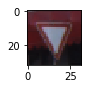

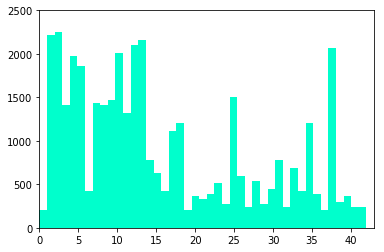

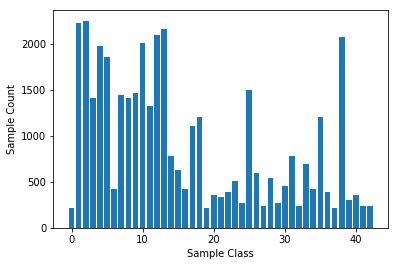

/Users/mahidhar/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/mahidhar/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/mahidhar/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


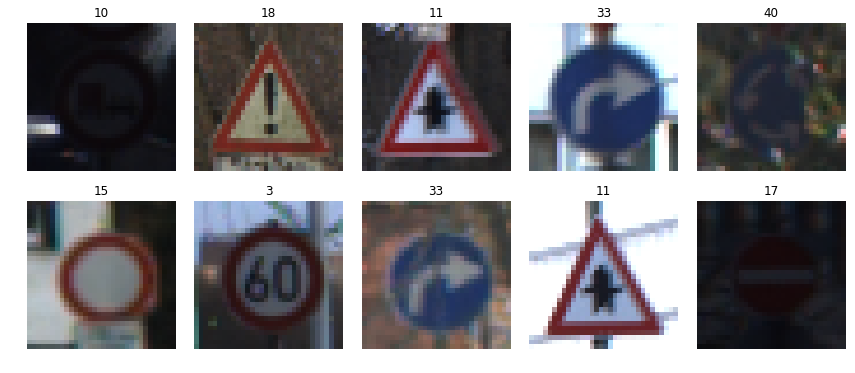

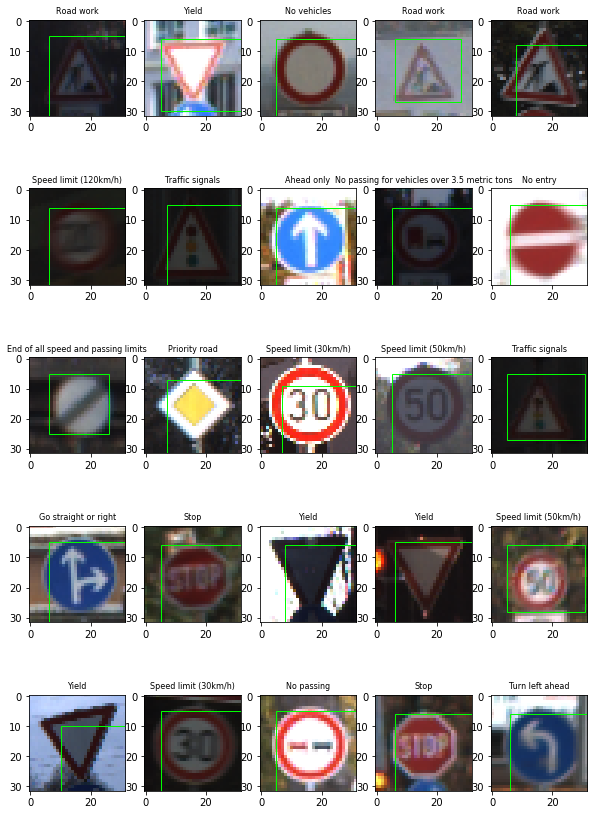

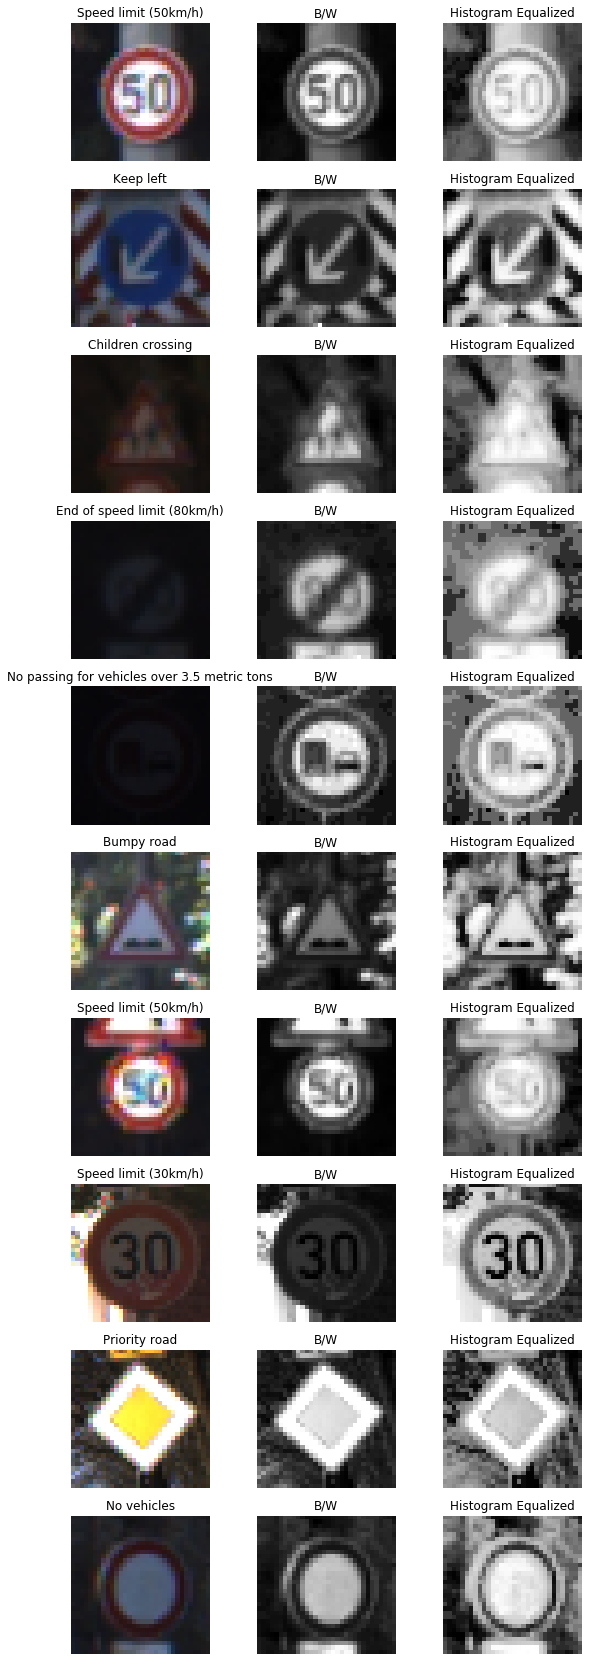

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

sign_names = []
with open('signnames.csv') as f:
    reader = csv.DictReader(f)
    sign_names = [line['SignName'] for line in reader]
print(sign_names)

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

hist, bins = np.histogram(y_train, bins=n_classes)
plt.figure()
plt.hist(y_train, bins=n_classes, color='#00ffCC')
plt.axis([0, 43, 0, 2500])
plt.show()

# plotting the count of each sign

y_pos = range(n_classes)
label_list = y_train.tolist()
sign_type = [label_list.count(y) for y in range(n_classes)]

plt.bar(y_pos, sign_type, width=0.8, align='center')
plt.ylabel('Sample Count')
plt.xlabel('Sample Class')
plt.show()

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])
    
num_x = 5
num_y = 5
fig, ax = plt.subplots(num_y,num_x)
fig.set_size_inches(10,15)
for i in range(num_x*num_y):
    n = random.random()*n_train
    ax[int(i/num_x)][i%num_x].imshow(X_train[n])
    coords = C_train[n]
    rect = patches.Rectangle((coords[0],coords[1]),coords[2]-coords[0],coords[3]-coords[1],edgecolor='#00ff00',facecolor='none')
    ax[int(i/num_x)][i%num_x].add_patch(rect)
    ax[int(i/num_x)][i%num_x].set_title(sign_names[y_train[n]], fontsize=8)

plt.show()

# show image of N random data points
count = 10
fig, axs = plt.subplots(count, 3, figsize=(count, count*3))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(0, count*3, 3):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(sign_names[y_train[index]])

    bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    axs[i+1].axis('off')
    axs[i+1].imshow(bw, cmap='gray')
    axs[i+1].set_title("B/W")

    equ = cv2.equalizeHist(bw)
    axs[i+2].axis('off')
    axs[i+2].imshow(equ, cmap='gray')
    axs[i+2].set_title("Histogram Equalized")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import scipy.ndimage
import numpy as np

def augment_brightness_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def create_variant(image):
    if (random.choice([True, False])):
        image = scipy.ndimage.interpolation.shift(image, [random.randrange(-5, 5), random.randrange(-5, 5), 0])
    if (random.choice([True, False])):
        image = scipy.ndimage.interpolation.rotate(image, random.randrange(-15, 15), reshape=False)
    return image

# convert to B/W
X_train_bw = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_train])
X_test_bw = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_test])

# apply histogram equalization
X_train_hst_eq = np.array([cv2.equalizeHist(image) for image in X_train_bw])
X_test_hst_eq = np.array([cv2.equalizeHist(image) for image in X_test_bw])

# reshape for conv layer
X_train_reshaped = X_train_hst_eq[..., np.newaxis]
X_test_reshaped = X_test_hst_eq[..., np.newaxis]
print('Before shaping:', X_train_hst_eq.shape)
print('After shaping:', X_train_reshaped.shape)

# normalize range
X_train_normalized = (X_train_reshaped - np.mean(X_train_reshaped)) / 128.0
X_test_normalized = (X_test_reshaped - np.mean(X_test_reshaped)) / 128.0
print('Mean before normalizing:', np.mean(X_train_reshaped), np.mean(X_test_reshaped))
print('Mean after normalizing:', np.mean(X_train_normalized), np.mean(X_test_normalized))

Before shaping: (39209, 32, 32)
After shaping: (39209, 32, 32, 1)
Mean before normalizing: 131.701958599 131.743169088
Mean after normalizing: 1.04568842668e-16 -6.65128416846e-17


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

0 210 7
1 2220 1
2 2250 1
3 1410 1
4 1980 1
5 1860 1
6 420 4
7 1440 1
8 1410 1
9 1470 1
10 2010 1
11 1320 1
12 2100 1
13 2160 1
14 780 2
15 630 2
16 420 4
17 1110 1
18 1200 1
19 210 7
20 360 4
21 330 5
22 390 4
23 510 3
24 270 6
25 1500 1
26 600 2
27 240 6
28 540 3
29 270 6
30 450 3
31 780 2
32 240 6
33 689 2
34 420 4
35 1200 1
36 390 4
37 210 7
38 2070 1
39 300 5
40 360 4
41 240 6
42 240 6


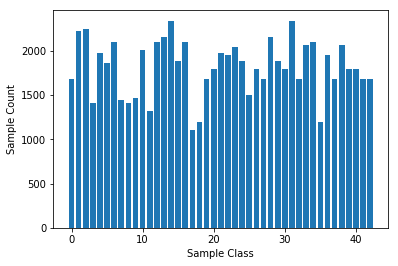

Number of training examples = 39209
Number of validation examples = 15654
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
from sklearn.model_selection import train_test_split

### Generate additional data (OPTIONAL!)
REQ_NUM_SAMPLES = 1500
generated_features = []
generated_labels = []

for class_index in range(len(sign_type)):
    class_sample_count = sign_type[class_index]
    augment_multiple = round(REQ_NUM_SAMPLES / class_sample_count)
    print(class_index, class_sample_count, augment_multiple)

    if augment_multiple <= 1:
        continue
    
    for test_feature, test_label in zip(X_train_normalized, y_train):
        if class_index == test_label:
            for augment_iter in range(augment_multiple):
                generated_features.append(create_variant(test_feature))
                generated_labels.append(test_label)

# append generated data to original data
X_train_augmented = np.append(np.array(X_train_normalized), np.array(generated_features), axis=0)
y_train_augmented = np.append(np.array(y_train), np.array(generated_labels), axis=0)
X_train, y_train = shuffle(X_train, y_train)

y_pos = range(n_classes)
label_list = y_train_augmented.tolist()
sign_type = [label_list.count(y) for y in range(n_classes)]

plt.bar(y_pos, sign_type, width=0.8, align='center')
plt.ylabel('Sample Count')
plt.xlabel('Sample Class')
plt.show()

### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
# split the training set into training set and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train_augmented, y_train_augmented, test_size=0.20, random_state=7)

                                                                # validation examples
n_validation = len(X_validation)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
                                                                
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))                                                                

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 30
BATCH_SIZE = 256

tf.set_random_seed(0.0)
# variable learning rate
lr = tf.placeholder(tf.float32)
# test flag for batch norm
tst = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)
# dropout probability
pkeep = tf.placeholder(tf.float32)

def batchnorm(Ylogits, is_test, iteration, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.9999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, 0.0, 1.0, bnepsilon)
    return Ybn, update_moving_everages

def no_batchnorm(Ylogits, is_test, iteration, convolutional=False):
    return Ylogits, tf.no_op()

class Conv2d(object):
    def __init__(self, 
                 nb_features, 
                 nb_rows, 
                 nb_cols,
                 strides=1,
                 input_shape = None 
                 activation=tf.nn.relu,
                 mean = 0,
                 stddev = 0.1,
                 padding = 'VALID',
                 pkeep = None):
        self.nb_features = nb_features
        self.nb_rows = nb_rows
        self.nb_cols = nb_cols
        self.strides = [1, strides, strides, 1]
        self.activation = activation
        self.pkeep = pkeep
        self.W = tf.Variable(tf.truncated_normal(shape = ksize.append(features), 
                                                 mean = self.mean, 
                                                 stddev = self.stddevv))
        self.B = tf.Variable(tf.zeros(nb_features))
        #self.B = tf.Variable(tf.constant(0.1, tf.float32, [features]))
        self.Y = None
        if input_shape:
            x = tf.placeholder(tf.float32, (None,) + input_shape)
            self.Y = tf.nn.conv2d(X, self.W, strides=self.strides, padding=self.padding) + self.B
            self.Y = self.activation(self.Y)

    def Y(self, X=None):
        if X:
            self.Y = tf.nn.conv2d(X, self.W, strides=self.strides, padding=self.padding) + self.B
            self.Y = self.activation(self.Y)            
        return self.Y
        
class MaxPool(object):
    def __init__(self, X = x, ksize = ksize, strides = strides, padding = 'VALID'):
        self.X = x
        self.strides = [1, strides, strides, 1]
        self.padding = padding
        self.ksize = ksize
        self.Y = tf.nn.max_pool(X, 
                              ksize=self.ksize, 
                              strides=self.strides, 
                              padding=self.padding)
    def Y(self, X):
        return self.Y
    
class FC(object):
    def __init__(self, 
                 in_dim = in_dim, 
                 out_dim = out_dim,
                 activation = tf.nn.relu,
                 mean = 0,
                 stddev = 0.1
                 pkeep = None):
        self.X = x
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.activation = activation
        self.pkeep = pkeep
        self.W = tf.Variable(tf.truncated_normal(shape=(in_dim, out_dim), 
                                                 mean = mean, 
                                                 stddev = stddev))
        self.B = tf.Variable(tf.zeros(features))
        self.Y = tf.matmul(self.X, self.W) + self.B
        self.Y = self.activation(Y)
    
    def Y(self, X):
        return self.Y
        
class ConvNetModel(object):
    def __init__(self, 
                 model = model,
                 train = train, 
                 validation = validation, 
                 test = test):
        self._train = train
        self._validation = validation
        self._test = test
        self._last_layer = None
    
    def add(self, data):
        self._last_layer = data.Y(self._last_layer)
        return self._last_layer
            
                    
model = ConvNetModel()
model.add(Conv2d(6, 5, 5, input_shape = (32, 32, 1), strides=1))
model.add(MaxPool(ksize=[1,2,2,1], strides=2))
model.add(Conv2d(16, 5, 5))
model.add(MaxPool(ksize=[1,2,2,1], strides=2))
model.add(flatten())
model.add(FC(in_dim = 400, out_dim = 120))
model.add(FC(y, in_dim = 120, out_dim = 84))
model.add(FC(y, in_dim = 84, out_dim = 43))


def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    #conv1bn, update_ema1 = batchnorm(conv1, tst, iter, convolutional=True)

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    #conv2bn, update_ema2 = batchnorm(conv2, tst, iter, convolutional=True)

    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    #fc1bn, update_ema3 = batchnorm(fc1, tst, iter)

    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    #fc2bn, update_ema4 = batchnorm(fc2, tst, iter)
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2d   = tf.nn.dropout(fc2, pkeep)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2d, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, tst: True, pkeep: 0.75})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, tst: True, pkeep: 0.75})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.603

EPOCH 2 ...
Validation Accuracy = 0.743

EPOCH 3 ...
Validation Accuracy = 0.803

EPOCH 4 ...
Validation Accuracy = 0.835

EPOCH 5 ...
Validation Accuracy = 0.852

EPOCH 6 ...
Validation Accuracy = 0.868

EPOCH 7 ...
Validation Accuracy = 0.883

EPOCH 8 ...
Validation Accuracy = 0.895

EPOCH 9 ...
Validation Accuracy = 0.899

EPOCH 10 ...
Validation Accuracy = 0.905

EPOCH 11 ...
Validation Accuracy = 0.908

EPOCH 12 ...
Validation Accuracy = 0.912

EPOCH 13 ...
Validation Accuracy = 0.916

EPOCH 14 ...
Validation Accuracy = 0.918

EPOCH 15 ...
Validation Accuracy = 0.919

EPOCH 16 ...
Validation Accuracy = 0.928

EPOCH 17 ...
Validation Accuracy = 0.930

EPOCH 18 ...
Validation Accuracy = 0.924

EPOCH 19 ...
Validation Accuracy = 0.934

EPOCH 20 ...
Validation Accuracy = 0.935

EPOCH 21 ...
Validation Accuracy = 0.940

EPOCH 22 ...
Validation Accuracy = 0.935

EPOCH 23 ...
Validation Accuracy = 0.939

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.904


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.